In [27]:
# Import packages
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")
print(drug_safety.head())

   age   sex   trx  week  wbc  rbc adverse_effects  num_effects
0   62  male  Drug     0  7.3  5.1              No            0
1   62  male  Drug     1  NaN  NaN              No            0
2   62  male  Drug    12  5.6  5.0              No            0
3   62  male  Drug    16  NaN  NaN              No            0
4   62  male  Drug     2  6.6  5.1              No            0


First, let's review the dataset.

In [29]:
print(drug_safety.info())
print(drug_safety.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              16103 non-null  int64  
 1   sex              16103 non-null  object 
 2   trx              16103 non-null  object 
 3   week             16103 non-null  int64  
 4   wbc              9128 non-null   float64
 5   rbc              9127 non-null   float64
 6   adverse_effects  16103 non-null  object 
 7   num_effects      16103 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1006.6+ KB
None
                age         week          wbc          rbc   num_effects
count  16103.000000  16103.00000  9128.000000  9127.000000  16103.000000
mean      64.117556      7.74098     7.340557     4.672784      0.101596
std        8.783207      6.94350     1.996652     0.458520      0.323181
min       39.000000      0.00000     1.800000     2.100000      0.0000

Although there are nulls in wbc and rbc, these columns are not used in the analysis and are thereby not important. All other columns have no missing values and all their statistics appear logical.

In [30]:
drug_safety.dropna(subset=['wbc', 'rbc'], inplace=True)

Our first task is to determine if the proportion of adverse effects differs significantly between the Drug and Placebo groups. To accomplish this, we will use a proportions z test from statsmodels. Let's first analyze the matrix of reported adverse affects and whether the respondents took the drug or the placebo.

adverse_effects    No  Yes
trx                       
Drug             5434  577
Placebo          2829  287


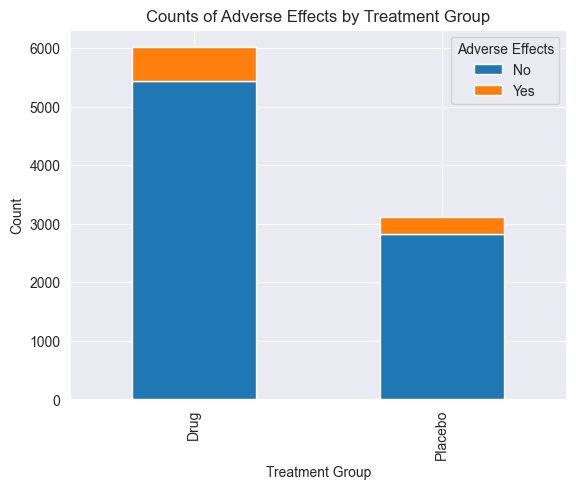

In [31]:
counts = drug_safety.groupby('trx')['adverse_effects'].value_counts().unstack(fill_value=0)
print(counts)

counts.plot(kind='bar', stacked=True)
plt.title('Counts of Adverse Effects by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('Count')
plt.legend(title='Adverse Effects', labels=['No', 'Yes'])
plt.show()

Now we can determine whether the adverse affects differ significantly between groups.

In [32]:
n_effects = counts['Yes'].values
n_rows = counts.sum(axis=1).values

z_score, p_value = proportions_ztest(count=n_effects, nobs=n_rows, alternative='two-sided')
two_sample_p_value = p_value
print(f"Proportion test p-value: {two_sample_p_value}")

Proportion test p-value: 0.547679650819394


Since the p-value is ~0.55, it suggests that any observed difference in the proportion of adverse effects between the two groups could be due to random chance rather than a real effect of the medication. We cannot conclude that the medication causes adverse effects.

For our second task, we want to find out if the number of adverse effects is independent of the treatment and control groups. To accomplish this, we will use a **Chi-Squared Test for Independence** model using the pingouin package. This test is used to determine if there is a significant association between two categorical variables.

We first must create a grouping by control and treatment group for the num_effects column before normalizing it by the size of the observations. This is due to the experiment having a 2:1 ratio of drug to placebo observations. Then we can plot the relative proportion of num_effects for each group.

num_effects     0    1   2  3
trx                          
Drug         5434  541  33  3
Placebo      2829  271  15  1
num_effects         0         1         2         3
trx                                                
Drug         0.904009  0.090002  0.005490  0.000499
Placebo      0.907895  0.086970  0.004814  0.000321


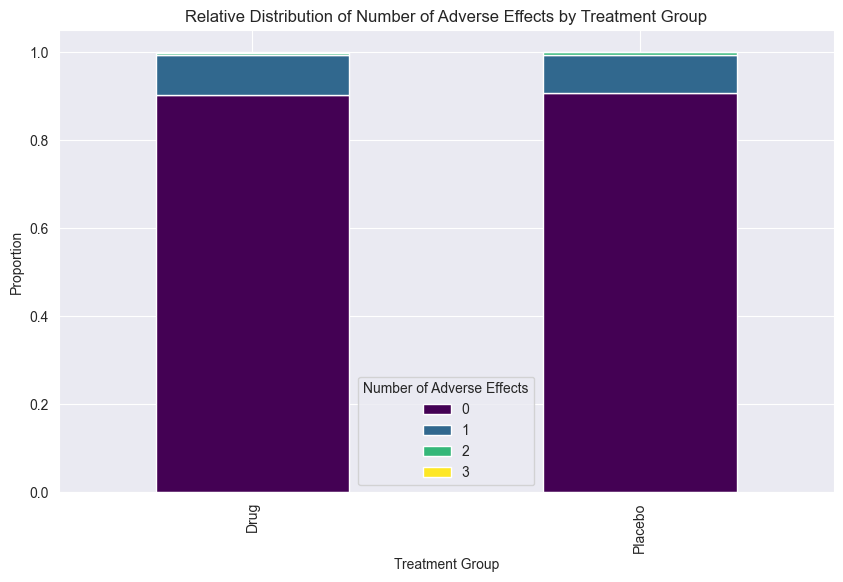

In [33]:
# Visualization: Relative distribution of num_effects by treatment group
# Calculate the proportions for num_effects within each treatment group
num_effects_counts = drug_safety.groupby(['trx', 'num_effects']).size().unstack(fill_value=0)
print(num_effects_counts)
num_effects_proportions = num_effects_counts.div(num_effects_counts.sum(axis=1), axis=0)
print(num_effects_proportions)
# Plot the normalized counts to compare the relative distribution
num_effects_proportions.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Relative Distribution of Number of Adverse Effects by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('Proportion')
plt.legend(title='Number of Adverse Effects')
plt.show()

Visually, there does not seem to be any difference in the reported number of adverse effects between the groups, further supporting the claim that the drug does not have any statistically significant side effects.

In [34]:
expected, observed, stats = pg.chi2_independence(data=drug_safety, x='num_effects', y='trx', correction=False)
num_effects_p_value = stats.iloc[0]['pval']
print(f"Chi-squared test p-value: {num_effects_p_value}")

Chi-squared test p-value: 0.9025511923375615


C:\Users\Mikey\OneDrive\Python\venv\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
C:\Users\Mikey\OneDrive\Python\venv\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn(f"Low count on {name} frequencies.")


This finding is confirmed by the extremely large p-value of 0.9.

Finally, we want to determine if there is a significant difference between the ages of the drug and placebo groups. To accomplish this, we will first create two series for the ages of the drug group and the ages of the placebo group. First, let's visualize the age groups.

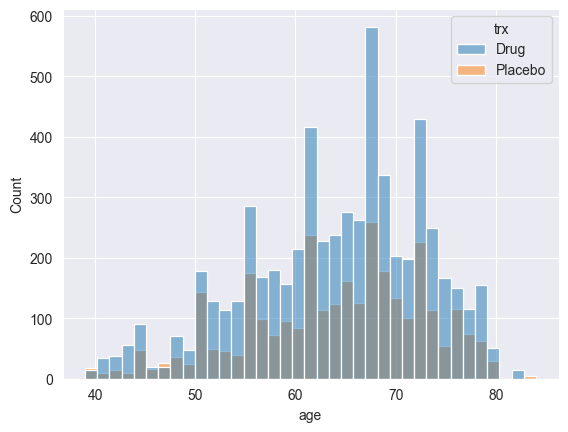

In [35]:
sns.histplot(data=drug_safety, x='age', hue='trx')
plt.show()

Given that there are more drug participants, we can ignore the size of the bars and see that the distribution looks relatively similar. Since this distribution is not normal, we can use a non-parameter test to determine the statistical significance. I've chosen the **Wilcoxon-Mann-Whitney** test using pingouin again.

In [36]:
drug_age = drug_safety[drug_safety['trx'] == 'Drug']['age']
placebo_age = drug_safety[drug_safety['trx'] == 'Placebo']['age']

mwu = pg.mwu(x=drug_age, y=placebo_age, alternative='two-sided')
age_group_effects_p_value = mwu['p-val']
print(age_group_effects_p_value)

MWU    0.699351
Name: p-val, dtype: float64


The result is another large p-value, suggesting that the difference of ages between the groups is not significant and thereby not a confounding factor of the reported adverse effects.

## Results
1. **Proportion of Adverse Effects**:
   The p-value from the proportion test is 0.54. Since this p-value is greater than the common significance level of 0.05, we fail to reject the null hypothesis. This indicates that there is no statistically significant difference in the proportion of adverse effects between the Drug and Placebo groups. Therefore, we cannot conclude that the medication causes these adverse effects.
2. **Number of Adverse Effects**:
   The p-value from the chi-squared test is 0.63. Again, since this p-value is greater than 0.05, we fail to reject the null hypothesis. This suggests that the number of adverse effects is independent of the treatment and control groups, meaning there is no significant association between the number of adverse effects and whether a participant received the drug or placebo.
3. **Age Distribution**:
   The p-value from the Mann-Whitney U test is 0.76. Since this p-value is greater than 0.05, we fail to reject the null hypothesis. This implies that there is no significant difference in the ages of individuals between the Drug and Placebo groups.

## Conclusion
Based on the statistical analysis, we have the following conclusions:
1. **Adverse Effects Proportion**: There is no significant difference in the proportion of adverse effects between the Drug and Placebo groups. Therefore, we do not have evidence to suggest that the medication causes adverse effects more frequently than the placebo.
2. **Number of Adverse Effects**: The number of adverse effects experienced by participants is independent of whether they received the drug or the placebo. This indicates no significant relationship between the treatment type and the count of adverse effects.
3. **Age Distribution**: The age distribution between the Drug and Placebo groups is not significantly different. This confirms that any observed effects are not likely due to age differences between the groups.
